# **Expectation Maximization and Gaussian Mixture Models (GMM)**

 ### Membres du Groupe 3 
  Nom  | Prenom  | Matricule 
:------|:--------:|----------:
 NYA NJIKE| ARMEL | 21S2802   

> ### 1. **Context et concepts clés**



>L'algorithme Gaussian Mixture Models (GMM) est un algorithme d'apprentissage non supervisé. Le GMM est classé dans les algorithmes de clustering, car il peut être utilisé pour trouver des clusters dans les données. Les concepts clés dont vous devriez avoir entendu parler sont :
 - Distribution gaussienne multivariée
 - Matrice de covariance
 - Vecteur moyen de données multivariées

 **Nous voulons utiliser des modèles de mélange gaussien pour trouver des clusters dans un ensemble de données à partir duquel nous connaissons (ou supposons connaître) le nombre de clusters contenus dans cet ensemble de données, mais nous ne savons pas où se trouvent ces clusters ni comment ils sont façonnés.** Trouver ces clusters est la tâche du GMM. Nous essayons de **trouver un certain nombre de distributions gaussiennes** qui peuvent être utilisées pour décrire la forme de notre ensemble de données.
 > ### 2. **PRINCIPE** 
 >> Comme son nom l'indique, un **modèle de mélange gaussien implique le mélange** (c'est-à-dire la superposition) de plusieurs distributions gaussiennes. Ici, plutôt que d'identifier les clusters par les centroïdes "les plus proches", nous ajustons un ensemble de k gaussiennes aux données. Et nous estimons les paramètres de distribution gaussienne tels que la moyenne et la variance pour chaque cluster et le poids d'un cluster. Après avoir appris les paramètres de chaque point de données, nous pouvons calculer les probabilités qu'il appartienne à chacun des clusters.

 > ### 2. **Pourquoi GMM**
 >> Si nous avons des données où nous supposons que les clusters ne sont pas définis par de simples cercles mais par des formes ellipsoïdes plus complexes, nous préférons l'approche GMM à l'approche KNN.
 >>De même que K-mean les GMM peuvent être utilisé pour classer les données : Quoi qu'il y ait plusieurs avantages à utilisé GMM
 >>> * k-means ne tient pas compte de la variance(qui définissent la forme de la distribution)
 >>> * K-mean place un cercle au centre de chaque cluster ( Inadéquat si les données ne sont pas circulaires )
 >>> * GMM prend en compte plusieurs formes de modèle
 >>> * **K-mean fait une classification deterministe où GMM est plutôt soft**
 >>>> *In Sklearn,gmm.predict(X) the model assigns every data point to one of the clusters and  gmm.predict_proba(X) function return the* probabilities that a data point belongs to each of the K clusters*

 ### **CAS PRATIQUE** : Construction d'un modèle GMM


**Rappelez-vous que nous voulons avoir K modèles gaussiens ajustés à nos K groupes de données. Alors, comment pouvons-nous faire en sorte que ces trois guassiens choisis au hasard s'adaptent automatiquement aux données ?**
>> Nous utilisons ici une approche appelée **espérance-maximisation (EM)**, qui est particulièrement populaire pour l'ajustement d'un tas de gaussiennes aux données.

#### - Description du jeux de données
> C'est un jeux de données contenant des données de cartes de credits

In [2]:
from scipy.stats import norm
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from pandas import DataFrame 
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture 
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
import os
#os.chdir("./TP ML")
wd = os.getcwd()
wd


'/home/armelnjike/Documents/SEMESTRE 8/MACHINE LEARNING/2023/TP ML'

In [3]:

#d_f = pd.read_csv('.C')
wd = os.getcwd()

raw_df = pd.read_csv('./CC GENERAL.csv')
raw_df = raw_df.drop('CUST_ID', axis = 1) 
raw_df.fillna(method ='ffill', inplace = True) 
raw_df.head(2)

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.4,0.0,95.4,0.000000,0.166667,0.0,0.083333,0.00,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.0,0.0,0.0,6442.945483,0.000000,0.0,0.000000,0.25,4,0,7000.0,4103.032597,1072.340217,0.222222,12


#### Normalisation des données

In [16]:
# Standardize data
scaler = StandardScaler() 
scaled_df = scaler.fit_transform(raw_df) 
  
# Normalizing the Data 
normalized_df = normalize(scaled_df) 
  
# Converting the numpy array into a pandas DataFrame 
normalized_df = pd.DataFrame(normalized_df) 
  
# Reducing the dimensions of the data 
pca = PCA(n_components = 3) 
X_principal = pca.fit_transform(normalized_df) 
X_principal = pd.DataFrame(X_principal) 

X_principal.columns = ['P1', 'P2','P3'] 
X_principal = X_principal.iloc[:500,:]
  
X_principal.head(2)
X_principal = np.stack((X_principal.P1 ,X_principal.P2, X_principal.P3)).flatten()
#plt.scatter(X_principal.P1,X_principal.P2,X_principal.P3)

In [17]:
"""Create the array r with dimensionality nxK"""
r = np.zeros((len(X_principal),3))  
print('Dimensionality','=',np.shape(r))

Dimensionality = (1500, 3)


#### Instancier une gaussienne Standard

In [18]:
gauss_1 = norm(loc=-5,scale=5) 
gauss_2 = norm(loc=8,scale=3)
gauss_3 = norm(loc=1.5,scale=1)

"""Instantiate the random pi_c"""
pi = np.array([1/3,1/3,1/3]) # We expect to have three clusters 



#### Probabilité pour chaque point d'appartenir à la gaussienne g

In [19]:
for c,g,p in zip(range(3),[gauss_1,gauss_2,gauss_3],pi):
    r[:,c] = p * g.pdf(X_principal) # Écrivez la probabilité que x appartienne à la gaussienne c dans la colonne c.
                          # Avec cela, nous obtenons un tableau 26850x3 rempli avec la probabilité que chaque x_i appartienne à l'une des gaussiennes
print('Dimensionality','=',np.shape(r))

Dimensionality = (1500, 3)


$r_ic$ est la probabilité que $x_i$ soit dans le cluster c
Ainsi, chaque ligne i dans r nous donne la probabilité pour $x_i$
appartenir à une gaussienne (une colonne par gaussienne).

In [20]:
"""Normaliser les probabilités de sorte que chaque ligne de r soit égale à 1
"""
for i in range(len(r)):
    r[i] = r[i]/(np.sum(r,axis=1)[i])

"""Dans le dernier calcul nous avons normalisé les probabilités r_ic(proba que x_i dans cluster c).  Since we want to know the probability
 that x_i belongs 
to gaussian g, we have to do smth. like a simple calculation of percentage where we want to know how likely it is in %  that
x_i belongs to gaussian g. To realize this, we must dive the probability of each r_ic by the total probability r_i (this is done by 
summing up each row in r and divide each value r_ic by sum(np.sum(r,axis=1)[r_i] )). To get this,
look at the above plot and pick an arbitrary datapoint. Pick one gaussian and imagine the probability that this datapoint
belongs to this gaussian. This value will normally be small since the point is relatively far away right? So what is
the percentage that this point belongs to the chosen gaussian? --> Correct, the probability that this datapoint belongs to this 
gaussian divided by the sum of the probabilites for this datapoint for all three gaussians."""
    
print(r)
print(np.sum(r,axis=1)) # As we can see, as result each row sums up to one, just as we want it.


[[0.48016514 0.02191924 0.49791562]
 [0.49574255 0.02190041 0.48235704]
 [0.17962562 0.02013139 0.80024299]
 ...
 [0.33650447 0.02147357 0.64202197]
 [0.13146458 0.02019691 0.8483385 ]
 [0.28798059 0.02109919 0.69092022]]
[1. 1. 1. ... 1. 1. 1.]


**Maintenant , on a les probabilités pour chaques $x_i$ d'appartenier à une gaussienne g**
> #### But initial : Nous voulons ajuster autant de gaussiennes aux données.
>> Maintenant, il serait probablement le cas qu'un cluster se compose de plus de points de données qu'un autre et ainsi la probabilité pour chaque $x_i$ d'appartenir à ce "grand" cluster est beaucoup plus grande que d'appartenir à l'un des autres.
>> On l'implemente, en multipliant la probabilité pour chaque $r_ic$ avec la fraction de points que nous supposons appartenir à ce cluster c. **On appelle cette variable $\pi_c$**

#### Affichage des données

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

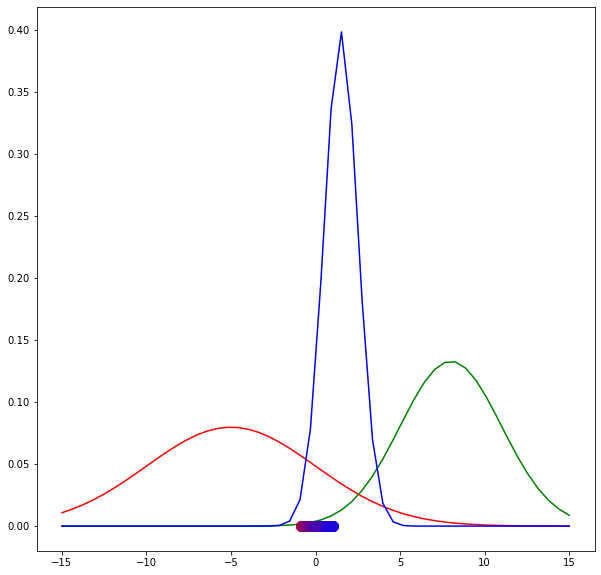

In [21]:
"""Plot the data"""

fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)


for i in range(len(r)):
    ax0.scatter(X_principal[i],0,c=np.array([r[i][0],r[i][1],r[i][2]]),s=100) # We have defined the first column as red, the second as
                                                                        # green and the third as blue



for g,c in zip([gauss_1.pdf(np.linspace(-15,15)),gauss_2.pdf(np.linspace(-15,15)),gauss_3.pdf(np.linspace(-15,15))],['r','g','b']):
    ax0.plot(np.linspace(-15,15),g,c=c,zorder=0)

    
    
plt.show()

### 3. Algorithme
> ### - Etape d'estimation 
>  On a définit le nombre de cluster qu'on veut ajuster a nos données
>>On va initialiser les paramètres : **Moyenne** $\mu_c$  , la **covariance** $\sigma_c$ et le **poid de cluster** $\pi_c$ pour chaque cluster c

Calcul de $r_ic$

>>>>>> ## $r_ic = \frac{\pi_c * N(x_i | \mu_c , \Sigma_c)}{\sum_{k = 1}^{n}{\pi_k N(x_i | \mu_k, \Sigma_k )}}$

$N(x_i, \mu , \Sigma)$ décrit la Gaussienne multivalué avec : $N(x_i | \mu_c , \Sigma_c) = \frac{1}{ (2 \pi)^{\frac{n}{2}}| \Sigma_c |^ {\frac{1}{2} } } \exp(\frac{-1}{2}(x_i - \mu_c)^T \Sigma_c^{-1}(x_i - \mu_c) ) $